In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [6]:
df = pd.read_csv('bbca_2000_2024.csv', skiprows=2)  
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.dropna(inplace=True)
df.set_index('Date', inplace=True)
print(df.head())

                 Close        High        Low        Open     Volume
Date                                                                
2004-06-08   99.696083  101.100253  98.291913   98.291913  499150000
2004-06-09  101.100258  102.504428  98.291917   99.696088  294290000
2004-06-10  101.100258  101.100258  99.696088  101.100258  165590000
2004-06-11  101.100258  101.100258  99.696088   99.696088  135830000
2004-06-14   99.696083  101.100253  98.291913  101.100253  158540000


In [7]:
train_df = df['2004':'2019']
test_df = df['2020':'2024']

In [8]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

In [10]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)

C:\Users\sdhih\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 0.0106
Epoch 2/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0012
Epoch 3/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0011
Epoch 4/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 9.9939e-04
Epoch 5/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0010
Epoch 6/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 7.6360e-04
Epoch 7/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 9.4062e-04
Epoch 8/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 8.9306e-04
Epoch 9/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 7.0664e-04
Epoch 10/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 7.5819e-04
Epoch 11/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 6.0397e-04
Epoch 12/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 8.9292e-04
Epoch 13/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 6.0846e-04
Epoch 14/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 5.1908e-04
Ep

In [11]:
predicted_scaled = model.predict(X_test)

dummy = np.zeros((len(predicted_scaled), scaled_test.shape[1]))
dummy[:, 0] = predicted_scaled[:, 0]
predicted_close = scaler.inverse_transform(dummy)[:, 0]

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [12]:
actual_close = test_df['Close'].values[sequence_length:]

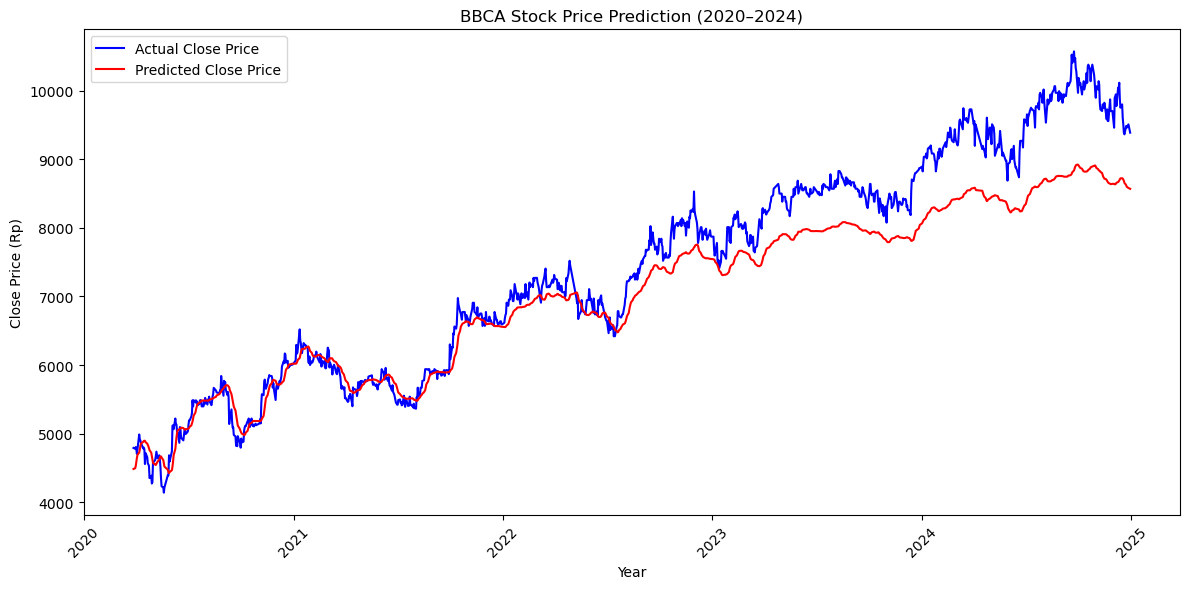

In [27]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.plot(test_df.index[sequence_length:], actual_close, color='blue', label='Actual Close Price')
plt.plot(test_df.index[sequence_length:], predicted_close, color='red', label='Predicted Close Price')
plt.title('BBCA Stock Price Prediction (2020–2024)')
plt.xlabel('Year')
plt.ylabel('Close Price (Rp)')
plt.legend()


plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45) 
plt.tight_layout()  

plt.show()


In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual_close, predicted_close)
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Akurasi Model (approx): {accuracy:.2f}%")

MAPE: 5.14%
Akurasi Model (approx): 94.86%
